# Transformers for Language Modeling

<center>
    <img src="transformers.png">
</center>

### Introduction

We will be implementing a Transformer, `SastaGPT`, from scratch. This will be taken from the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). We will then train this Transformer on a language modeling task on a dataset of our choosing.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import tiktoken

import re

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

from gpt4all import Embed4All

import torch
import torch.nn as nn
# from google.colab import drive
# drive.mount('/content/drive')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Creating a Dataset

In this section, we will be creating a dataset for training our Transformer. We are allowed to use any dataset we want, as long as it is a text dataset.

Some fun options include:

- A collection of movie scripts from our favorite director. Look through [IMSDB](https://www.imsdb.com/) for some options.

- A novel from our favorite author. Look through [Project Gutenberg](https://www.gutenberg.org/) for some options.

- A collection of poems from our favorite poet. Look through [Poetry Foundation](https://www.poetryfoundation.org/) for some options.

- Anything else from [Kaggle](https://www.kaggle.com/datasets) or [HuggingFace](https://huggingface.co/datasets).

In [ ]:
#The reason i chose this movie was first this was the first movie that came to mind, this is the best Nolan movie ever produced as per the public, the best movie of batman till date, and a movie I will definately watch reading half of the script and loving the plot though I have already seen a lot of snippets of this movie on different social media handles.
#another thing i noticed was that this movie has sophistiated storytelling and an intricate plot. It features a range of characters each with a different speaking style such as bane and batman. training model on such a varied dataset can help it learn on how to deal with different variations of the same language.
#The choice allows for an exploration of how well Transformer-based models can capture and reproduce the intricacies of a professionally written screenplay, including dialogue, scene descriptions, and action sequences. This can provide insights into the strengths and limitations of current language models.

In [ ]:
BATCH_SIZE = 128
BLOCK_SIZE = 8

# Create tiktoken object
encoder = tiktoken.get_encoding("gpt2")

# Read in your dataset
with open("/kaggle/input/batman/THE DARK KNIGHT RISES.txt", 'r', encoding='utf-8') as file:
    script_text = file.read()

def remove_punctuation(txt):

   return re.sub(r'[\n@#$%^&*_+={}[\]:;<>/~`"\;\\|]', ' ', txt)

def remove_lines(txt):
  return re.sub(r'\n+', ' ', txt)

def remove_whitespace(txt):
  return re.sub(r'\s+', ' ', txt)

def remove_numbers(txt):

    return re.sub(r'\d+', '', txt)

def remove_url(txt):

    return re.sub(r'http\S+', '', txt)

def normalize_sentence(txt):
    '''
    Aggregates all the above functions to normalize/clean a sentence
    '''

    # txt = lowercase(txt)
    txt = remove_url(txt)
    txt = remove_punctuation(txt)
    txt = remove_numbers(txt)
    txt = remove_lines(txt)
    txt = remove_whitespace(txt)
    # txt = remove_stopwords(txt)
    return txt

normalized_script = normalize_sentence(script_text)

encoded_ids = encoder.encode(normalized_script)


def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    # Get random integers for indexing into the dataset to create a batch
    start = np.random.randint(0, len(encoded_ids) - BLOCK_SIZE, BATCH_SIZE)

    # Initialize x and y as empty lists
    x = []
    y = []

    # Get the x and y (input and target) batches after encoding and indexing
    for i in range(BATCH_SIZE):
        shuru = start[i]
        khatam = shuru + BLOCK_SIZE + 1
        x.append(encoded_ids[shuru:khatam-1])
        y.append(encoded_ids[shuru+1:khatam])

    # Convert lists to tensors and add a batch dimension
    x_tensor = torch.tensor(x, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.long)

    return x_tensor, y_tensor


xb, yb = get_batch()
xb.shape, yb.shape

S. Goyer BLACK SCREEN. GORDON (V.O) Harvey Dent was needed. He was everything Gotham has been crying out for. He was...a hero. Not the hero we deserved - the hero we needed. Nothing less than a knight, shining... The sound of cracking. Splintering. A shape appears, in ice. The shape of a BAT. The ice disintegrates... EXT. GOTHAM STREET - DAY Gordon stands before a massive picture of Harvey Dent. GORDON But I knew Harvey Dent. I was...his friend. And it will be a very long time before someone inspires us the way he did. Gordon, choked with emotion, gathers the papers of his eulogy. I believed in Harvey Dent. And we FADE TO BLACK. CUT TO Racing along a cratered dirt road, and we are - INT. LAND CRUISER JOSTLING OVER UNEVEN TERRAIN - DAY Three Hooded Men guarded by East European Militia. A third Militia drives. Next to him is a nervous, bespectacled man. EXT. AIRSTRIP, EASTERN EUROPE - DAY An airstrip overlooking a grey city rocked by artillery fire. A bland CIA Operative, flanked by Spec

(torch.Size([128, 8]), torch.Size([128, 8]))

## Creating the Transformer

### Defining our Hyperparameters

We will define our hyperparameters here. 

Since there are lots of hyperparameters to keep track of, it is easier for us to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. Down the line, we'd be concatenating these heads together, so the final output would be of size 512 again.

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If we were to use character-level tokenization, this would be the number of unique characters in our dataset. Since we should be using subword-level tokenization, this will be the number of unique subwords in our dataset.

In [4]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256*2
    head_size: int = 32
    num_heads: int = 16
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

# We like to have emb_dim == head_size * num_heads
config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Multi-Head Self-Attention 

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers).

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.


In [ ]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads

        # Define the single projection layer for QKV
        self.qkv = nn.Linear(self.emb_dim, 3 * self.emb_dim)  # Shape: (B, T, C) -> (B, T, C * 3)

        # Define the output projection layer
        self.proj = nn.Linear(self.emb_dim, self.emb_dim)  # Shape: (B, T, C) -> (B, T, C)
        #After the projection, the output shape becomes (B, T, 3 * C) because this layer creates queries, keys, and values concatenated together, each of size C.

        # Create a buffer for the mask (buffers are tensors that are not updated during backpropagation)
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads
        mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)

        # Carry out the projections to get the query, key and value - you may want to reshape them to (B, H, T, head_size) to make things easier
        qkv = self.qkv(x).reshape(B, T, 3, H, self.head_size)  # Shape: (B, T, C * 3) -> (B, T, 3, H, head_size) The reshaped tensor has the shape (B, T, 3, H, head_size), where H is the number of heads.
        #The purpose of this reshaping is to split the concatenated queries, keys, and values and to organize them according to the number of heads. Each head processes a portion (head_size) of the embedding dimension (C).
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Shape: (3, B, H, T, head_size)
        #The dimensions are rearranged as follows:
        #2 (the first number in permute) moves the third dimension (which is 3 for Q, K, V) to the first position.
        #0 moves the original first dimension (batch size B) to the second position.
        #3 moves the original fourth dimension (number of heads H) to the third position.
        #1 moves the original second dimension (sequence length T) to the fourth position.
        #4 keeps the last dimension (head_size) in its place.
        #The reshaping and permutation prepare the data for parallel processing across multiple attention heads.
        q, k, v = qkv[0], qkv[1], qkv[2]
        # Compute the attention scores, perform masking, and apply the softmax
        scores = torch.matmul(q, k.transpose(-2, -1)) / ((self.head_size)**2)  # Shape: (B, H, T, T)
        scores = scores.masked_fill(self.mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)

        # Compute the weighted sum of the value vectors - you can perform the concatenation via a simple reshaping before applying the final projection
        out = torch.matmul(attn, v)  # Shape: (B, H, T, head_size)
        out = out.transpose(1, 2).reshape(B, T, C)  # Shape: (B, T, H, head_size) -> (B, T, C)
        out = self.proj(out)
        return out

x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 512])
torch.Size([32, 8, 512])


### Feedforward Network

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.


1. Use the [GELU Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) instead of ReLU between the layers. It is functionally very similar, but has gained a lot of popularity recently.

2. Instead of using two `Linear` layers, and an upsampling factor of `4`, use **three** `Linear` layers: the first one upsamples by a factor of `2`, the second one does not change the dimensionality, and the third one downsamples by a factor of `2`. This creates a slightly deeper network, and can be shown to have the same number of parameters as the network in the original Transformer.

3. Add a [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the last `Linear` layer, with $p=0.1$. This helps mitigate overfitting.

In [ ]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        emb_dim = config.emb_dim

        # Define the feedforward network
        self.linear1 = nn.Linear(emb_dim, 2 * emb_dim)
        self.linear2 = nn.Linear(2 * emb_dim, 2 * emb_dim)
        self.linear3 = nn.Linear(2 * emb_dim, emb_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=0.1)


    def forward(self, x):
        # Apply the feedforward network
        x = self.gelu(self.linear1(x))
        x = self.gelu(self.linear2(x))
        x = self.dropout(self.linear3(x))

        return x

### Blocks with Skip Connections

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

- Instead of creating our own Layer Normalization module, use [the one provided by PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), `nn.LayerNorm`.

- Perform the Layer Normalizations **before** the Skip Connections, instead of after. The original paper used the "post-LN" approach, but [recent research](https://arxiv.org/abs/2002.04745) has shown that the "pre-LN" approach is better.

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Define the MHSA, Feedforward, and two LayerNorm modules
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.mhsa = MHSA(config)
        self.feedforward = Feedforward(config)

    def forward(self, x):

        # Apply the modules with residual connections (use the Pre-LN design)
        x = x + self.mhsa(self.norm1(x))
        x = x + self.feedforward(self.norm2(x))

        return x

x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 512])
torch.Size([8, 8, 512])


### Putting it all together

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.


In [ ]:
class SastaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size

        # Define the word and position embeddings
        self.token_embeddings = nn.Embedding(self.vocab_size, self.emb_dim)
        self.position_embeddings = nn.Embedding(self.block_size, self.emb_dim)

        # Define the sequence of Blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(self.num_layers)])

        # Define the final LayerNorm
        self.ln_f = nn.LayerNorm(self.emb_dim)

        # Define the final linear layer (to get logits)
        self.head = nn.Linear(self.emb_dim, self.vocab_size)

        # Initialize the weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        # idxs: (B, T)
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"

        # Get the word embeddings (B, T, C) and position embeddings (T, C)
        # Hint: For the position embeddings, you can use torch.arange(seq_len) to mimic the indices
        # Note: position embeddings are encodings of the position indices (NOT the actual tokens)
        token_embeddings = self.token_embeddings(idxs)  # (B, T, C)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=idxs.device)
        position_embeddings = self.position_embeddings(position_ids)  # (T, C)

        # Add the word and position embeddings (broadcasting will take care of the shapes)
        x = token_embeddings + position_embeddings.unsqueeze(0)  # Broadcasting

        # Pass the embeddings through the blocks (B, T, C)
        for block in self.blocks:
            x = block(x)

        # Apply the final LayerNorm
        x = self.ln_f(x)

        # Apply the final linear layer to get the logits (B, T, V)
        logits = self.head(x)

        return logits

    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        '''

        # idxs: (B, T)
        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V)

            logits = logits[:, -1, :] # (B, V)

            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)

        return idxs

cfg = Config()
model = SastaGPT(cfg)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 57.823M


In [ ]:
# Check out the forward pass
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([128, 8])
torch.Size([128, 8, 50257])


Now train this model on our own dataset!

Note that since the model is quite large, it will take a while to train. This would be a good opportunity to use [Google Colab](https://colab.research.google.com/) or [Kaggle Notebooks](https://www.kaggle.com/notebooks) for free GPU compute. This requires very few changes to your original training code, only having to cast your model and data to the GPU.

```python
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the batch
xb, yb = get_batch()

# Cast to the device
xb = xb.to(device)
yb = yb.to(device)

# Cast the model to the device
model = model.to(device)

# Forward pass
preds = model(xb)

...

```

The only rule is that both your model and your tensors should be on the same device (CPU or GPU).

In [ ]:
# Train the model
import torch.optim as optim
from tqdm import tqdm

config = Config()
model = SastaGPT(config)


device = torch.device("cuda")

# Cast the model to the device
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs and early stopping parameters
num_epochs = 15000  
best_loss = float('inf')
stagnant_epochs = 0
patience = 1  
min_delta = 0.01  
model.train()
# Training Loop
for epoch in range(num_epochs):
    # model.train()
    # total_loss = 0
    xb, yb = get_batch()  # Get a batch of data
    xb = xb.to(device)
    yb = yb.to(device)
    progress_bar = tqdm(range(5), desc=f"Epoch {epoch+1}/{num_epochs}")
    for _ in progress_bar: 
        # xb, yb = get_batch()  # Get a batch of data
        # xb = xb.to(device)
        # yb = yb.to(device)

        # Forward pass
        preds = model(xb)

        # Compute loss and backpropagate
        loss = criterion(preds.view(-1, config.vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # total_loss += loss.item()
        # progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1)})

    # avg_loss = total_loss / 100  # Adjust based on actual number of batches
    if (epoch+1)%1000 == 0:
     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')




Epoch 1000/15000: 100%|██████████| 5/5 [00:00<00:00, 109.50it/s]


Epoch 1000/15000, Loss: 0.6798


Epoch 2000/15000: 100%|██████████| 5/5 [00:00<00:00, 101.62it/s]


Epoch 2000/15000, Loss: 0.6228


Epoch 3000/15000: 100%|██████████| 5/5 [00:00<00:00, 104.39it/s]


Epoch 3000/15000, Loss: 0.5784


Epoch 4000/15000: 100%|██████████| 5/5 [00:00<00:00, 98.53it/s]


Epoch 4000/15000, Loss: 0.5697


Epoch 5000/15000: 100%|██████████| 5/5 [00:00<00:00, 102.31it/s]


Epoch 5000/15000, Loss: 0.5874


Epoch 6000/15000: 100%|██████████| 5/5 [00:00<00:00, 103.02it/s]


Epoch 6000/15000, Loss: 0.6087


Epoch 7000/15000: 100%|██████████| 5/5 [00:00<00:00, 106.34it/s]


Epoch 7000/15000, Loss: 0.5602


Epoch 8000/15000: 100%|██████████| 5/5 [00:00<00:00, 105.85it/s]


Epoch 8000/15000, Loss: 0.5732


Epoch 9000/15000: 100%|██████████| 5/5 [00:00<00:00, 108.45it/s]


Epoch 9000/15000, Loss: 0.5614


Epoch 10000/15000: 100%|██████████| 5/5 [00:00<00:00, 105.91it/s]


Epoch 10000/15000, Loss: 0.5331


Epoch 11000/15000: 100%|██████████| 5/5 [00:00<00:00, 106.67it/s]


Epoch 11000/15000, Loss: 0.5405


Epoch 12000/15000: 100%|██████████| 5/5 [00:00<00:00, 104.72it/s]


Epoch 12000/15000, Loss: 0.5330


Epoch 13000/15000: 100%|██████████| 5/5 [00:00<00:00, 107.80it/s]


Epoch 13000/15000, Loss: 0.5912


Epoch 14000/15000: 100%|██████████| 5/5 [00:00<00:00, 106.31it/s]


Epoch 14000/15000, Loss: 0.6018


Epoch 15000/15000: 100%|██████████| 5/5 [00:00<00:00, 101.79it/s]


Epoch 15000/15000, Loss: 0.5519


With your trained model, generate some text. You can use the `generate()` function.

Note that the quality of your generations depends on:

- How large the training dataset was. If you used a small dataset, your model will not have enough samples to learn the syntax, semantics, the grammar and other intricacies of language, much less the specifics of the dataset.

- How long you trained for. Provided your dataset was large enough, you could try training for longer epochs until the loss values stabilize.

- How large your model was. If you used a small model, it will not have enough parameters to learn the complexities of language. You can try increasing the number of layers, the embedding dimensionality, the number of heads, etc.

In [12]:
# Check out the generate method
model = model.to("cpu")
model.eval()
sentence = "The dark knight was the absolute hero of the town."
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)
idxs = idxs.to("cpu")
# model.eval()
generated = model.generate(idxs, max_new_tokens=500)
res = encoder.decode(generated[0].numpy())
print(res)

The dark knight was the absolute hero of the town. BLAKE Sir, what's down there. . BLAKE We know what's down there, sir. The Police Commissioner! FOLEY Somebody get the hothead out of here. And get me a DWP guy! Blake backs off. Gets an idea - goes for his patrol car. INT. SEWERS - CONTINUOUS Gordon hears a noise up ahead - pushes forward, rounds the corner. BANG! GUNFIRE. SWATs return fire, shots sparking off the concrete walls, then - BOOM - behind him the tunnel ERUPTS IN FIRE, blasting the SWATs. Gordon races forward, tearing through the tunnels. EXT. ALLEY BEHIND BAR - CONTINUOUS Blake pushes forward. BLAKE Come on, we gotta get down there - COP That was a gas explosion, kid - BLAKE Gas? This is fine the use it gets these days. FOX Well, then I have just the thing for an eccentric billionaire who doesn't like to walk... Fox opens a door - we glimpse a sleek vehicle. Wayne's eyes light up. . WAYNE Now you're just showing off. FOX Defense Department project for tight-geometry urban 

In [ ]:
#Another Output: The dark knight was the absolute hero of the town. BLAKE But how do we -? KAABOOOM! The Bat's cannons light up the night. BLAKE Okay. Cops climb out into the cold night - skinny, ragged, but glad to be alive and carrying guns... BLAKE What now? BATMAN All-out assault on Bane...but you need to get the people you care about across the bridge. BLAKE Why? BATMAN In case we fail. Lead an exodus across the bridge. Save as many lives as you can. BLAKE Don't you need me here? BATMAN You've given me an army. Now go. Blake nods. Turns to leave. Stops. . BLAKE Thank you. BATMAN Don't thank me yet. BLAKE I might not get a chance later. Batman nods. Blake disappears into the night. EXT. GOTHAM STREET - CONTINUOUS The -wheeler pulls up. A line of Gothamites waits patiently along the sidewalk. INT. -WHEELER - CONTINUOUS Three plain-clothes Special Forces Men emerge from the boxes, checking, then concealing weapons. The doors open - they exit. INT. SUPERMARKET - CONTINUOUS The Special Forces Men carry boxes into the store as if delivering. The Store Manager leads them into the back and down into - INT. LOWER STOREROOM - CONTINUOUS CAPTAIN JONES What about the triggerman? GORDON No leads. It's a bluff - Bane wouldn't give control of that bomb to someone else. CAPTAIN JONES We can't take that chance. Until we have the triggerman, we just track the device, smuggle men over - BLAKE While Gotham lives under a warlord, like in some failed state? CAPTAIN JONES Dial it back, officer. This situation is unprecedented. We can't do anything to risk millions of lives. BLAKE (TO GORDON) Aren't you gonna tell him?! GORDON Captain, things are more complicated than you think. There's somebody you need to meet. Blake? Blake nods, leads Jones and his men up to machines. Wayne, in ski mask, stands over him. Gordon's eyes flutter open. He tries to speak with a weak, hoarse voice... GORDON We were in this together. Then you were gone... WAYNE The Batman wasn't needed anymore. We won.

## Effects of Hyperparameters on the Number of Parameters 

In this section, we will be exploring the effects of the hyperparameters on the number of parameters in your model.

With so much room for tweaking (with the embedding dimensionality, the size of the vocab, the number of heads, the number of layers, etc.), it is important to visualize how fast the total number of parameters can grow if you start toying with them.

In [13]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    # block_size: int = BLOCK_SIZE
    # emb_dim: int = 256
    # head_size: int = 32
    # num_heads: int = 8
    # num_layers: int = 2
    # vocab_size: int = 100 # smaller vocab size for quick prototyping
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256*2
    head_size: int = 32
    num_heads: int = 16
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

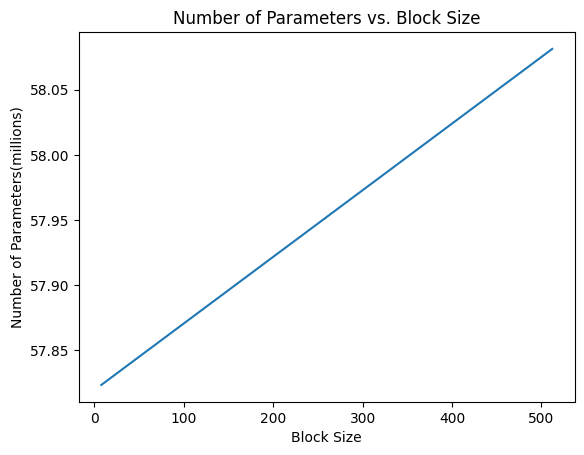

In [ ]:
# Plot the number of parameters vs. block size (in multiples of 8, capped at 512)
size = [8,16,32,64,128,256,512]
parameters=[]
for s in size:
    config = Config(block_size=s)
    model = SastaGPT(config)
    parameters.append(get_params(model))

plt.plot(size, parameters)
plt.xlabel('Block Size')
plt.ylabel('Number of Parameters(millions)')
plt.title('Number of Parameters vs. Block Size')
plt.show()

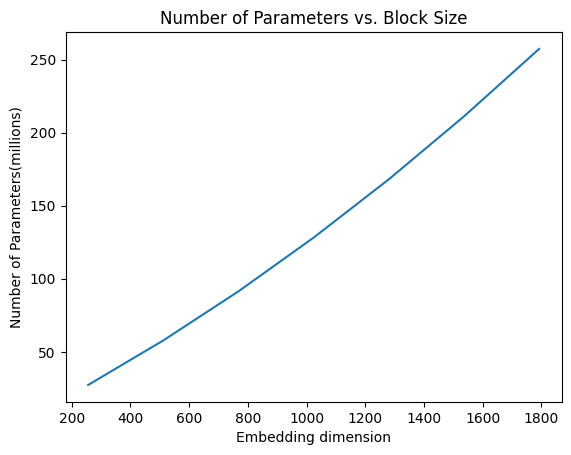

In [ ]:
# Plot the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)
size = [256, 512, 768, 1024, 1280, 1536, 1792]
parameters=[]
for s in size:
    config = Config(emb_dim=s)
    model = SastaGPT(config)
    parameters.append(get_params(model))

plt.plot(size, parameters)
plt.xlabel('Embedding dimension')
plt.ylabel('Number of Parameters(millions)')
plt.title('Number of Parameters vs. Block Size')
plt.show()

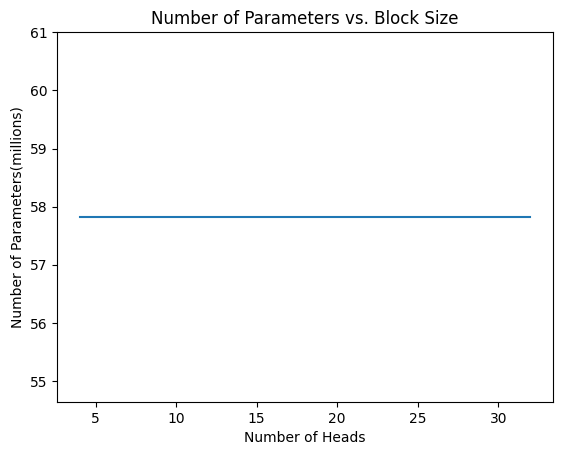

In [ ]:
# Plot the number of parameters vs. number of heads (in multiples of 4, capped at 32)
size = [4,8,12,16,20,24,28,32]
parameters=[]
for s in size:
    config = Config(num_heads=s)
    model = SastaGPT(config)
    parameters.append(get_params(model))

plt.plot(size, parameters)
plt.xlabel('Number of Heads')
plt.ylabel('Number of Parameters(millions)')
plt.title('Number of Parameters vs. Block Size')
plt.show()

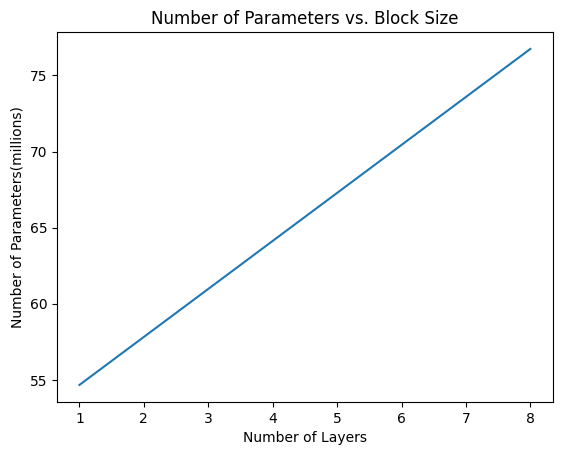

In [ ]:
# Plot the number of parameters vs. number of layers
size = [1,2,3,4,5,6,7,8]
parameters=[]
for s in size:
    config = Config(num_layers=s)
    model = SastaGPT(config)
    parameters.append(get_params(model))

plt.plot(size, parameters)
plt.xlabel('Number of Layers')
plt.ylabel('Number of Parameters(millions)')
plt.title('Number of Parameters vs. Block Size')
plt.show()

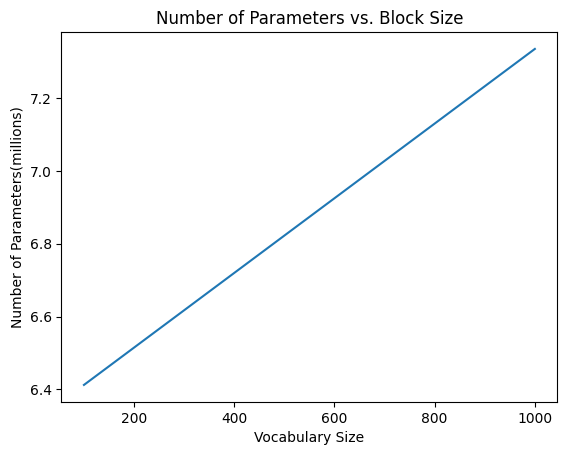

In [ ]:
# Plot the number of parameters vs. vocabulary size
size = [100,200,300,400,500,600,700,800,900,1000]
parameters=[]
for s in size:
    config = Config(vocab_size=s)
    model = SastaGPT(config)
    parameters.append(get_params(model))

plt.plot(size, parameters)
plt.xlabel('Vocabulary Size')
plt.ylabel('Number of Parameters(millions)')
plt.title('Number of Parameters vs. Block Size')
plt.show()